### 3. 신경망 학습 관련 기술들
##### 1. 매개변수 갱신
- 손실함수의 값을 가능한 한 낮추는 매개변수를 찾는 문제 >> 최적화(optimication) 문제
- 확률적 경사 하강법(SGD)
    - 매개변수의 기울기(미분)을 이용
    - 기울어진 방향으로 매개변수 값을 반복적으로 갱신
- **AdaGrad**
    - 학습률 : 너무 작으면 학습 시간이 너무 길어지고, 반대로 너무 크면 발산하여 올바른 학습을 하지 못함
    - 학습률 감소 (learnig rate decay) : 학습을 하면서 학습률을 하면서 점차 줄이는 방법
    - 과거 기울기를 제곱해서 계속 더함
- **Adam**
    - Momentum + AdaGrad

===========iteration:0===========
Adam:2.19996974904
Momentum:2.42005888015
SGD:2.37450583835
AdaGrad:2.16236561026
===========iteration:500===========
Adam:0.0730167192979
Momentum:0.133972683505
SGD:0.449692122689
AdaGrad:0.0365723931387
===========iteration:1000===========
Adam:0.0570867119862
Momentum:0.137703773478
SGD:0.400308872128
AdaGrad:0.0418098237819
===========iteration:1500===========
Adam:0.0324851326921
Momentum:0.0755161285612
SGD:0.244874781708
AdaGrad:0.0358305275914


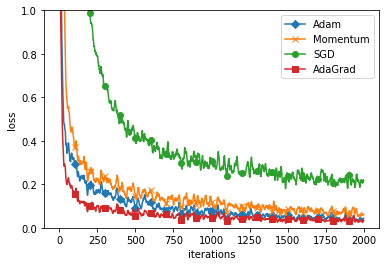

In [1]:
# MNIST 데이터로 본 갱신방법 비교
import os
import sys
#sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *

# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 1. 실험용 설정==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    

# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 500 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

# 3. 그래프 그리기==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

##### 2. 가중치의 초기값
- 가중치 감소(weight decay)
    - 가중치 매개변수의 값이 작아지도록 학습하는 방법
    - 과적합을 억제해 범용 성능을 높이는 기법


- 가중치 초기값을 0으로 하면?
    - 학습이 올바로 이뤄지지 않음 >> 오차역전파법에서 모든 가중치의 값이 똑같이 갱신되기 때문
    - 가중치를 균일한 값으로 설정해서는 안 됨
    - 초기값을 무작위로 설정해야 함

##### 은닉층의 활성화값 분포
- 가중치의 초기값에 다른 은닉층 활성화값들의 변화 시험
- 5층 신경망
- 무작위로 생성한 입력데이터 >> 각 층의 활성화값 분포를 histogram 사용
- 표준편차가 1인 경우
    - 각 층의 활성화값들이 0과 1에 치우쳐 분포 >> 출력이 0 또는 1에 가까울수록 미분이 0에 가까워짐
    - 기울기 소실(gradient vanishing) 문제
- 표준편차가 0.01인 경우
    - 0.5부근에 집중
    - 표현력의 제한 문제 (뉴런을 여러 개 둔 의미가 없어짐)

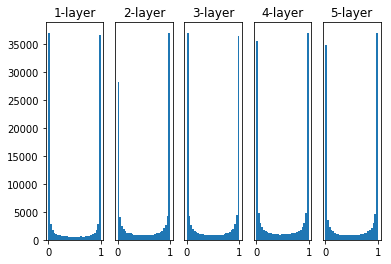

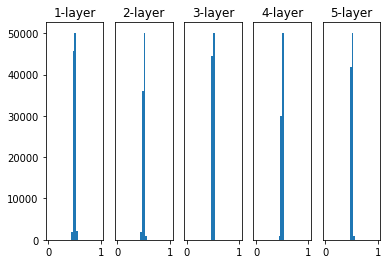

In [2]:
# 은닉층의 활성화값 분포
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험 (표준편차)
    w = np.random.randn(node_num, node_num) * 1
    # w = np.random.randn(node_num, node_num) * 0.01
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)

    a = np.dot(x, w)

    # 활성화 함수도 바꿔가며 실험해보기
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


##### Xavier 초기값
- 앞 계층의 노드가 n개라면 표준편차 sqrt(1/n)

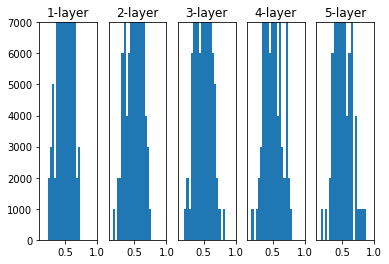

In [3]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험 (표준편차)
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    a = np.dot(x, w)
    z = sigmoid(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

##### He 초기값
- Relu에 특화된 초기값
- 앞 계층의 노드가 n개일 때, 표준편차가 sqrt(2/n)안 정규분포 사용

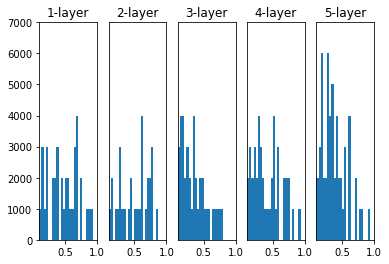

In [4]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험 (표준편차)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)
    a = np.dot(x, w)
    z = ReLU(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

===========iteration:0===========
He:2.2931834063
std=0.01:2.30252639583
Xavier:2.29142241187
===========iteration:500===========
He:0.410354525532
std=0.01:2.30185903077
Xavier:0.849184924712
===========iteration:1000===========
He:0.262761388659
std=0.01:2.30059210021
Xavier:0.469993774456
===========iteration:1500===========
He:0.28260488556
std=0.01:2.30246513167
Xavier:0.399046103534


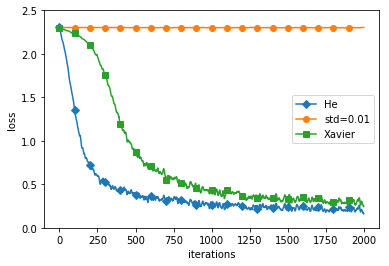

In [5]:
# 가중치 초기값 비교
import os
import sys
#sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 500 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()


##### 3. 배치 정규화
- 각 층의 활성화 값 분포가 적당히 퍼지면 학습이 원활하게 수행됨
- 강제로 각 층의 활성화를 적당히 퍼뜨리도록 강제화
- 학습 시 미니배치 단위로 정규화
- 데이터 분포가 평균이 0, 분산이 1이 되도록 정규화

============== 1/16 ==============
epoch:0 | 0.116 - 0.089


C:\Users\dnghw\Desktop\IT 신기술사관학교\day6\common\layers.py:12: RuntimeWarning: invalid value encountered in less_equal
  self.mask = (x <= 0)
C:\Users\dnghw\Desktop\IT 신기술사관학교\day6\common\multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C:\Users\dnghw\Desktop\IT 신기술사관학교\day6\common\multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.106
epoch:2 | 0.097 - 0.085
epoch:3 | 0.097 - 0.112
epoch:4 | 0.097 - 0.144
epoch:5 | 0.097 - 0.168
epoch:6 | 0.097 - 0.188
epoch:7 | 0.097 - 0.204
epoch:8 | 0.097 - 0.226
epoch:9 | 0.097 - 0.242
epoch:10 | 0.097 - 0.253
epoch:11 | 0.097 - 0.283
epoch:12 | 0.097 - 0.304
epoch:13 | 0.097 - 0.33
epoch:14 | 0.097 - 0.337
epoch:15 | 0.097 - 0.355
epoch:16 | 0.097 - 0.387
epoch:17 | 0.097 - 0.406
epoch:18 | 0.097 - 0.413

No handles with labels found to put in legend.



epoch:19 | 0.097 - 0.426
============== 2/16 ==============
epoch:0 | 0.097 - 0.091
epoch:1 | 0.097 - 0.118
epoch:2 | 0.097 - 0.138
epoch:3 | 0.097 - 0.154
epoch:4 | 0.097 - 0.165
epoch:5 | 0.097 - 0.176
epoch:6 | 0.097 - 0.197
epoch:7 | 0.097 - 0.222
epoch:8 | 0.097 - 0.24
epoch:9 | 0.097 - 0.252
epoch:10 | 0.097 - 0.277
epoch:11 | 0.097 - 0.306
epoch:12 | 0.097 - 0.328
epoch:13 | 0.097 - 0.353
epoch:14 | 0.097 - 0.368
epoch:15 | 0.097 - 0.397
epoch:16 | 0.097 - 0.405
epoch:17 | 0.097 - 0.42
epoch:18 | 0.097 - 0.439


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.449
============== 3/16 ==============
epoch:0 | 0.106 - 0.086
epoch:1 | 0.305 - 0.107
epoch:2 | 0.488 - 0.145
epoch:3 | 0.585 - 0.176
epoch:4 | 0.658 - 0.212
epoch:5 | 0.71 - 0.244
epoch:6 | 0.761 - 0.288
epoch:7 | 0.786 - 0.333
epoch:8 | 0.816 - 0.366
epoch:9 | 0.835 - 0.403
epoch:10 | 0.859 - 0.434
epoch:11 | 0.882 - 0.466
epoch:12 | 0.898 - 0.504
epoch:13 | 0.914 - 0.525
epoch:14 | 0.927 - 0.547
epoch:15 | 0.929 - 0.567
epoch:16 | 0.949 - 0.584
epoch:17 | 0.958 - 0.611
epoch:18 | 0.962 - 0.618


No handles with labels found to put in legend.


epoch:19 | 0.971 - 0.633
============== 4/16 ==============
epoch:0 | 0.134 - 0.116
epoch:1 | 0.256 - 0.128
epoch:2 | 0.372 - 0.172
epoch:3 | 0.467 - 0.255
epoch:4 | 0.542 - 0.302
epoch:5 | 0.612 - 0.372
epoch:6 | 0.651 - 0.42
epoch:7 | 0.682 - 0.475
epoch:8 | 0.701 - 0.516
epoch:9 | 0.736 - 0.567
epoch:10 | 0.753 - 0.608
epoch:11 | 0.776 - 0.637
epoch:12 | 0.787 - 0.653
epoch:13 | 0.789 - 0.669
epoch:14 | 0.811 - 0.693
epoch:15 | 0.819 - 0.704
epoch:16 | 0.832 - 0.72
epoch:17 | 0.844 - 0.734
epoch:18 | 0.85 - 0.747


No handles with labels found to put in legend.


epoch:19 | 0.86 - 0.758
============== 5/16 ==============
epoch:0 | 0.108 - 0.096
epoch:1 | 0.12 - 0.135
epoch:2 | 0.122 - 0.232
epoch:3 | 0.134 - 0.359
epoch:4 | 0.143 - 0.46
epoch:5 | 0.144 - 0.523
epoch:6 | 0.152 - 0.577
epoch:7 | 0.176 - 0.613
epoch:8 | 0.194 - 0.65
epoch:9 | 0.232 - 0.679
epoch:10 | 0.246 - 0.714
epoch:11 | 0.264 - 0.739
epoch:12 | 0.275 - 0.755
epoch:13 | 0.29 - 0.77
epoch:14 | 0.309 - 0.776
epoch:15 | 0.319 - 0.793
epoch:16 | 0.339 - 0.812
epoch:17 | 0.344 - 0.812
epoch:18 | 0.347 - 0.825


No handles with labels found to put in legend.


epoch:19 | 0.359 - 0.838
============== 6/16 ==============
epoch:0 | 0.048 - 0.128
epoch:1 | 0.141 - 0.221
epoch:2 | 0.155 - 0.462
epoch:3 | 0.117 - 0.596
epoch:4 | 0.121 - 0.675
epoch:5 | 0.118 - 0.736
epoch:6 | 0.116 - 0.771
epoch:7 | 0.116 - 0.808
epoch:8 | 0.116 - 0.828
epoch:9 | 0.116 - 0.846
epoch:10 | 0.116 - 0.862
epoch:11 | 0.116 - 0.884
epoch:12 | 0.116 - 0.893
epoch:13 | 0.116 - 0.9
epoch:14 | 0.116 - 0.918
epoch:15 | 0.116 - 0.926
epoch:16 | 0.116 - 0.928
epoch:17 | 0.116 - 0.94
epoch:18 | 0.116 - 0.942


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.949
============== 7/16 ==============
epoch:0 | 0.136 - 0.079
epoch:1 | 0.117 - 0.304
epoch:2 | 0.117 - 0.593
epoch:3 | 0.117 - 0.683
epoch:4 | 0.117 - 0.723
epoch:5 | 0.117 - 0.788
epoch:6 | 0.117 - 0.82
epoch:7 | 0.117 - 0.857
epoch:8 | 0.117 - 0.876
epoch:9 | 0.117 - 0.899
epoch:10 | 0.117 - 0.918
epoch:11 | 0.117 - 0.929
epoch:12 | 0.117 - 0.94
epoch:13 | 0.117 - 0.951
epoch:14 | 0.117 - 0.961
epoch:15 | 0.117 - 0.97
epoch:16 | 0.117 - 0.975
epoch:17 | 0.116 - 0.978
epoch:18 | 0.116 - 0.981
epoch:19 | 0.116 - 0.99

No handles with labels found to put in legend.



============== 8/16 ==============
epoch:0 | 0.117 - 0.099
epoch:1 | 0.116 - 0.189
epoch:2 | 0.116 - 0.598
epoch:3 | 0.1 - 0.741
epoch:4 | 0.116 - 0.82
epoch:5 | 0.117 - 0.86
epoch:6 | 0.117 - 0.914
epoch:7 | 0.116 - 0.934
epoch:8 | 0.116 - 0.956
epoch:9 | 0.116 - 0.969
epoch:10 | 0.116 - 0.972
epoch:11 | 0.117 - 0.979
epoch:12 | 0.117 - 0.987
epoch:13 | 0.117 - 0.988
epoch:14 | 0.116 - 0.994
epoch:15 | 0.116 - 0.997
epoch:16 | 0.116 - 0.997
epoch:17 | 0.116 - 0.997
epoch:18 | 0.116 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.999
============== 9/16 ==============
epoch:0 | 0.117 - 0.119
epoch:1 | 0.117 - 0.571
epoch:2 | 0.117 - 0.728
epoch:3 | 0.117 - 0.797
epoch:4 | 0.117 - 0.894
epoch:5 | 0.117 - 0.927
epoch:6 | 0.117 - 0.96
epoch:7 | 0.117 - 0.972
epoch:8 | 0.117 - 0.978
epoch:9 | 0.117 - 0.982
epoch:10 | 0.117 - 0.991
epoch:11 | 0.117 - 0.99
epoch:12 | 0.117 - 0.992
epoch:13 | 0.117 - 0.998
epoch:14 | 0.117 - 0.998
epoch:15 | 0.117 - 0.999
epoch:16 | 0.117 - 0.998
epoch:17 | 0.117 - 0.999
epoch:18 | 0.116 - 0.999


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.999
============== 10/16 ==============
epoch:0 | 0.116 - 0.117
epoch:1 | 0.105 - 0.575
epoch:2 | 0.116 - 0.777
epoch:3 | 0.117 - 0.826
epoch:4 | 0.117 - 0.871
epoch:5 | 0.116 - 0.871
epoch:6 | 0.116 - 0.866
epoch:7 | 0.116 - 0.884
epoch:8 | 0.116 - 0.975
epoch:9 | 0.116 - 0.985
epoch:10 | 0.117 - 0.988
epoch:11 | 0.117 - 0.995
epoch:12 | 0.117 - 0.991
epoch:13 | 0.117 - 0.994
epoch:14 | 0.117 - 0.998
epoch:15 | 0.117 - 0.967
epoch:16 | 0.117 - 0.88
epoch:17 | 0.117 - 0.981
epoch:18 | 0.116 - 0.999


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.997
============== 11/16 ==============
epoch:0 | 0.093 - 0.127
epoch:1 | 0.116 - 0.535
epoch:2 | 0.117 - 0.731
epoch:3 | 0.117 - 0.74
epoch:4 | 0.116 - 0.831
epoch:5 | 0.116 - 0.808
epoch:6 | 0.116 - 0.885
epoch:7 | 0.117 - 0.904
epoch:8 | 0.116 - 0.958
epoch:9 | 0.117 - 0.936
epoch:10 | 0.117 - 0.972
epoch:11 | 0.117 - 0.977
epoch:12 | 0.117 - 0.984
epoch:13 | 0.117 - 0.976
epoch:14 | 0.117 - 0.981
epoch:15 | 0.117 - 0.989
epoch:16 | 0.117 - 0.99
epoch:17 | 0.117 - 0.988
epoch:18 | 0.117 - 0.991


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.993
============== 12/16 ==============
epoch:0 | 0.116 - 0.11
epoch:1 | 0.105 - 0.55
epoch:2 | 0.116 - 0.723
epoch:3 | 0.116 - 0.743
epoch:4 | 0.116 - 0.675
epoch:5 | 0.116 - 0.766
epoch:6 | 0.116 - 0.748
epoch:7 | 0.116 - 0.793
epoch:8 | 0.116 - 0.789
epoch:9 | 0.116 - 0.796
epoch:10 | 0.116 - 0.804
epoch:11 | 0.116 - 0.878
epoch:12 | 0.116 - 0.891
epoch:13 | 0.116 - 0.875
epoch:14 | 0.116 - 0.893
epoch:15 | 0.116 - 0.89
epoch:16 | 0.116 - 0.891
epoch:17 | 0.116 - 0.895
epoch:18 | 0.116 - 0.897


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.894
============== 13/16 ==============
epoch:0 | 0.094 - 0.182
epoch:1 | 0.117 - 0.382
epoch:2 | 0.117 - 0.469
epoch:3 | 0.117 - 0.694
epoch:4 | 0.117 - 0.32
epoch:5 | 0.117 - 0.764
epoch:6 | 0.116 - 0.772
epoch:7 | 0.116 - 0.751
epoch:8 | 0.116 - 0.717
epoch:9 | 0.116 - 0.757
epoch:10 | 0.116 - 0.791
epoch:11 | 0.116 - 0.796
epoch:12 | 0.116 - 0.8
epoch:13 | 0.117 - 0.811
epoch:14 | 0.117 - 0.888
epoch:15 | 0.117 - 0.865
epoch:16 | 0.116 - 0.825
epoch:17 | 0.116 - 0.823
epoch:18 | 0.116 - 0.874


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.846
============== 14/16 ==============
epoch:0 | 0.099 - 0.14
epoch:1 | 0.116 - 0.468
epoch:2 | 0.116 - 0.479
epoch:3 | 0.116 - 0.549
epoch:4 | 0.116 - 0.551
epoch:5 | 0.116 - 0.594
epoch:6 | 0.116 - 0.604
epoch:7 | 0.116 - 0.581
epoch:8 | 0.116 - 0.607
epoch:9 | 0.116 - 0.613
epoch:10 | 0.117 - 0.618
epoch:11 | 0.117 - 0.607
epoch:12 | 0.117 - 0.609
epoch:13 | 0.117 - 0.643
epoch:14 | 0.117 - 0.622
epoch:15 | 0.117 - 0.587
epoch:16 | 0.117 - 0.614
epoch:17 | 0.117 - 0.674
epoch:18 | 0.117 - 0.667


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.647
============== 15/16 ==============
epoch:0 | 0.094 - 0.095
epoch:1 | 0.117 - 0.297
epoch:2 | 0.117 - 0.477
epoch:3 | 0.117 - 0.474
epoch:4 | 0.117 - 0.374
epoch:5 | 0.117 - 0.509
epoch:6 | 0.117 - 0.446
epoch:7 | 0.117 - 0.512
epoch:8 | 0.117 - 0.517
epoch:9 | 0.117 - 0.521
epoch:10 | 0.117 - 0.506
epoch:11 | 0.117 - 0.51
epoch:12 | 0.117 - 0.533
epoch:13 | 0.117 - 0.576
epoch:14 | 0.117 - 0.586
epoch:15 | 0.117 - 0.603
epoch:16 | 0.117 - 0.6
epoch:17 | 0.117 - 0.61
epoch:18 | 0.117 - 0.613
epoch:19 | 0.117 - 0.532


No handles with labels found to put in legend.


============== 16/16 ==============
epoch:0 | 0.117 - 0.211
epoch:1 | 0.116 - 0.297
epoch:2 | 0.116 - 0.382
epoch:3 | 0.116 - 0.439
epoch:4 | 0.105 - 0.463
epoch:5 | 0.116 - 0.468
epoch:6 | 0.116 - 0.495
epoch:7 | 0.116 - 0.501
epoch:8 | 0.116 - 0.458
epoch:9 | 0.116 - 0.497
epoch:10 | 0.116 - 0.505
epoch:11 | 0.116 - 0.498
epoch:12 | 0.116 - 0.508
epoch:13 | 0.116 - 0.505
epoch:14 | 0.116 - 0.507
epoch:15 | 0.116 - 0.507
epoch:16 | 0.116 - 0.508
epoch:17 | 0.116 - 0.506
epoch:18 | 0.116 - 0.498
epoch:19 | 0.116 - 0.508


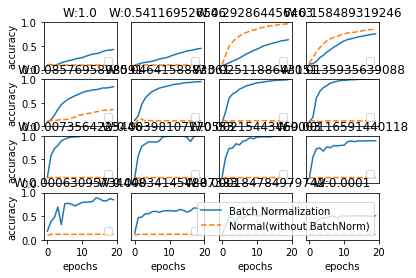

In [6]:
# 배치 정규화 효과
import sys, os
#sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()


##### 4. 과적합
- 신경망이 훈련 데이터에만 지나치게 적응되어 그 외 데이터에 제대로 대응X
- 매개변수가 많고 표현력이 높은 모델 or 훈련 데이터가 적은 경우 발생

epoch:0, train acc:0.0933333333333, test acc:0.0882
epoch:50, train acc:0.89, test acc:0.6947
epoch:100, train acc:1.0, test acc:0.744
epoch:150, train acc:1.0, test acc:0.7492
epoch:200, train acc:1.0, test acc:0.7521


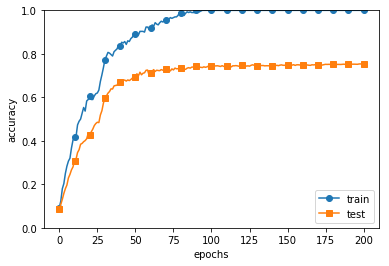

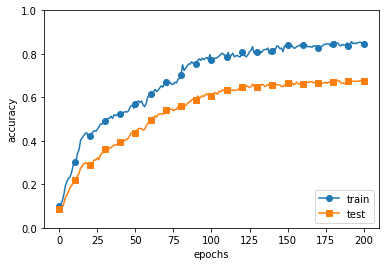

In [7]:
# 과적합 예제 (60,000개 데이터 중 300개 사용 // 7층 네트워크, 각 층의 뉴런은 100개)
import os
import sys
#sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
weight_decay_lambda = 0      # weight decay를 사용하지 않을 경우
weight_decay_lambdaN = 0.1 # 가중치 감소 사용 시
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
networkN = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambdaN)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신
optimizerN = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []
train_acc_listN = []
test_acc_listN = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    gradsN = networkN.gradient(x_batch, t_batch)
    optimizerN.update(networkN.params, gradsN)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        train_accN = networkN.accuracy(x_train, t_train)
        test_accN = networkN.accuracy(x_test, t_test)
        train_acc_listN.append(train_accN)
        test_acc_listN.append(test_accN)
        
        if epoch_cnt % 50 == 0:
            print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

plt.plot(x, train_acc_listN, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_listN, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

##### 드롭아웃(overfitting 해결)
- 뉴런을 임의로 삭제하면서 학습 > 뉴런을 무작위로 골라 삭제

train loss:2.30655501171
=== epoch:50, train acc:0.22, test acc:0.1839 ===
train loss:2.2732335735
train loss:2.25607997752
train loss:2.27595650089
=== epoch:100, train acc:0.23, test acc:0.2016 ===
train loss:2.1687275352
train loss:2.16081598452
train loss:2.17301540385
=== epoch:150, train acc:0.293333333333, test acc:0.2537 ===
train loss:2.13291776378
train loss:1.92320769892
train loss:2.01098934548
=== epoch:200, train acc:0.37, test acc:0.3129 ===
train loss:1.8206072411
train loss:2.04814518768
train loss:1.96721676472
=== epoch:250, train acc:0.44, test acc:0.3703 ===
train loss:1.89232490539
train loss:1.72803483021
train loss:1.84453865588
=== epoch:300, train acc:0.556666666667, test acc:0.4388 ===
train loss:1.80356648972
train loss:1.69917608856
train loss:1.49534790816
=============== Final Test Accuracy ===============
test acc:0.4441


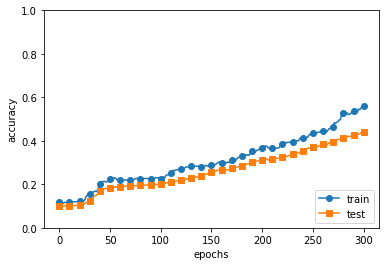

In [8]:
# coding: utf-8
import os
import sys
#sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


##### 5. 적절한 Hyper-parameter값 찾기
- training set : 매개변수 찾기
- validation set : 하이퍼파라미터 성능 평가
- test set : 신경망의 범용 성능 평가